In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/nslkdd/KDDTrain+.csv')
test_df = pd.read_csv('/content/drive/MyDrive/nslkdd/KDDTest+.csv')


In [ ]:
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Training set shape: (125973, 43)
Testing set shape: (22543, 43)


In [ ]:
print("\nClass Distribution in Training Set:")
print(train_df['label'].value_counts())
print("\nClass Distribution in Testing Set:")
print(test_df['label'].value_counts())



Class Distribution in Training Set:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Class Distribution in Testing Set:
label
normal             9710
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
sn

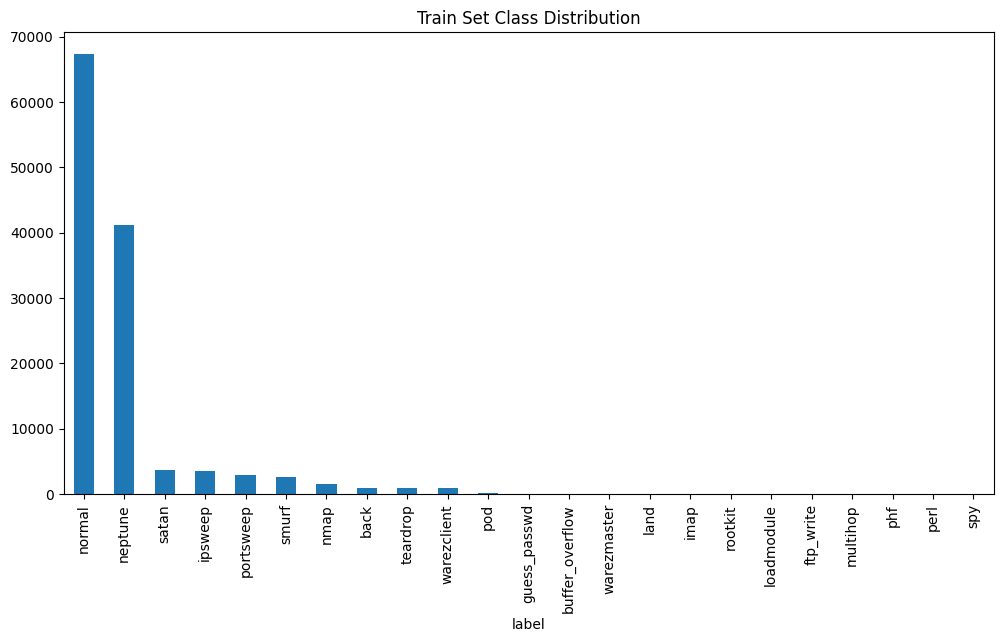

In [ ]:
plt.figure(figsize=(12, 6))
train_df['label'].value_counts().plot(kind='bar', title='Train Set Class Distribution')
plt.show()

In [ ]:
categorical_columns = ['protocoltype', 'service', 'flag']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

In [ ]:
numerical_columns = [col for col in train_df.columns if col not in categorical_columns + ['label']]
scaler = MinMaxScaler()
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

In [ ]:
def build_generator(input_dim, output_dim):
    return tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),  # Use Input layer explicitly
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation='tanh')
    ])


In [ ]:
def build_discriminator(input_dim):
    return tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),  # Use Input layer explicitly
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])


In [ ]:
class BEGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(BEGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(BEGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]

        # Generate fake data
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_data = self.generator(random_latent_vectors)

        # Train discriminator
        with tf.GradientTape() as d_tape:
            real_logits = self.discriminator(real_data)
            fake_logits = self.discriminator(fake_data)

            real_loss = self.loss_fn(tf.ones_like(real_logits), real_logits)
            fake_loss = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = real_loss + fake_loss

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

        # Train generator
        with tf.GradientTape() as g_tape:
            fake_data = self.generator(random_latent_vectors)
            fake_logits = self.discriminator(fake_data)
            g_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
# Get majority class count
target_count = train_df['label'].value_counts().max()
print(target_count)

67343


In [ ]:
# Balance all minority classes in the test dataset
for label, class_count in test_df['label'].value_counts().items():
    if class_count < target_count:
        print(f"Balancing test class: {label}")

        # Extract data for the minority class
        minority_data = test_df[test_df['label'] == label].drop('label', axis=1).to_numpy()

        # Define model dimensions
        input_dim = minority_data.shape[1]
        latent_dim = 100

        # Call build_generator to create an instance of the generator
        generator = build_generator(latent_dim, input_dim) # This line is added

        # Use the same trained generator for generating synthetic samples
        samples_needed = target_count - class_count
        random_latent_vectors = tf.random.normal((samples_needed, latent_dim))
        synthetic_data = generator(random_latent_vectors).numpy()

        # Add synthetic samples to the test dataset
        synthetic_df = pd.DataFrame(synthetic_data, columns=test_df.drop('label', axis=1).columns)
        synthetic_df['label'] = label
        test_df = pd.concat([test_df, synthetic_df], ignore_index=True)

Balancing test class: normal
Balancing test class: neptune
Balancing test class: guess_passwd
Balancing test class: mscan
Balancing test class: warezmaster
Balancing test class: apache2
Balancing test class: satan
Balancing test class: processtable
Balancing test class: smurf
Balancing test class: back
Balancing test class: snmpguess
Balancing test class: saint
Balancing test class: mailbomb
Balancing test class: snmpgetattack
Balancing test class: portsweep
Balancing test class: ipsweep
Balancing test class: httptunnel
Balancing test class: nmap
Balancing test class: pod
Balancing test class: buffer_overflow
Balancing test class: multihop
Balancing test class: named
Balancing test class: ps
Balancing test class: sendmail
Balancing test class: rootkit
Balancing test class: xterm
Balancing test class: teardrop
Balancing test class: xlock
Balancing test class: land
Balancing test class: xsnoop
Balancing test class: ftp_write
Balancing test class: worm
Balancing test class: loadmodule
Bal

In [ ]:
# Balance all minority classes
for label, class_count in train_df['label'].value_counts().items():
    if class_count < target_count:
        print(f"Balancing class: {label}")

        # Extract data for the minority class
        minority_data = train_df[train_df['label'] == label].drop('label', axis=1).to_numpy()

        # Define model dimensions
        input_dim = minority_data.shape[1]
        latent_dim = 100

        # Initialize generator and discriminator
        generator = build_generator(latent_dim, input_dim)
        discriminator = build_discriminator(input_dim)

        # Initialize BEGAN
        began = BEGAN(generator, discriminator, latent_dim)
        began.compile(
            g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=1.0),
            d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=1.0),
            loss_fn=tf.keras.losses.BinaryCrossentropy()
        )

        # Train BEGAN
        epochs = 20  # Reduced epochs
        batch_size = 64 # Smaller batch size
        for epoch in range(epochs):
            np.random.shuffle(minority_data)  # Shuffle data for each epoch
            for i in range(0, len(minority_data), batch_size):
                real_batch = minority_data[i:i + batch_size]
                logs = began.train_step(real_batch)

            if (epoch + 1) % 5 == 0:  # Reduced logging
                print(f"Epoch {epoch + 1}/{epochs} - D Loss: {logs['d_loss']:.4f}, G Loss: {logs['g_loss']:.4f}")

            # Early stopping
            if logs['d_loss'] < 0.01 and logs['g_loss'] < 1.0:
                print("Stopping early as losses are sufficiently low.")
                break

        # Generate synthetic data
        samples_needed = int(0.8 * (target_count - class_count))
        random_latent_vectors = tf.random.normal((samples_needed, latent_dim))
        synthetic_data = generator(random_latent_vectors).numpy()

        # Add synthetic samples to the training dataset
        synthetic_df = pd.DataFrame(synthetic_data, columns=train_df.drop('label', axis=1).columns)
        synthetic_df['label'] = label
        train_df = pd.concat([train_df, synthetic_df], ignore_index=True)



Balancing class: neptune
Epoch 5/20 - D Loss: 0.0002, G Loss: 8.7778
Epoch 10/20 - D Loss: 0.0000, G Loss: 11.2719
Epoch 15/20 - D Loss: 0.0000, G Loss: 13.4754
Epoch 20/20 - D Loss: 0.0000, G Loss: 14.5554
Balancing class: satan
Epoch 5/20 - D Loss: 0.0423, G Loss: 3.2443
Epoch 10/20 - D Loss: 0.0085, G Loss: 4.7933
Epoch 15/20 - D Loss: 0.0051, G Loss: 5.3600
Epoch 20/20 - D Loss: 0.0075, G Loss: 5.0272
Balancing class: ipsweep
Epoch 5/20 - D Loss: 0.0762, G Loss: 2.7051
Epoch 10/20 - D Loss: 0.0087, G Loss: 4.8163
Epoch 15/20 - D Loss: 0.0028, G Loss: 5.9540
Epoch 20/20 - D Loss: 0.0016, G Loss: 6.4648
Balancing class: portsweep
Epoch 5/20 - D Loss: 0.0632, G Loss: 2.8389
Epoch 10/20 - D Loss: 0.0148, G Loss: 4.3132
Epoch 15/20 - D Loss: 0.0093, G Loss: 5.2422
Epoch 20/20 - D Loss: 0.0039, G Loss: 5.6336
Balancing class: smurf
Epoch 5/20 - D Loss: 0.1046, G Loss: 2.3890
Epoch 10/20 - D Loss: 0.0127, G Loss: 4.4485
Epoch 15/20 - D Loss: 0.0044, G Loss: 5.5473
Epoch 20/20 - D Loss: 0.

In [ ]:
# Verify the new class distribution
print("\nNew Class Distribution:")
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())


New Class Distribution:
label
normal             67343
neptune            62117
satan              54601
ipsweep            54594
portsweep          54460
smurf              54403
nmap               54173
back               54065
warezclient        54052
teardrop           54052
pod                53914
guess_passwd       53885
buffer_overflow    53880
warezmaster        53878
land               53878
ftp_write          53876
rootkit            53876
imap               53876
loadmodule         53876
multihop           53875
phf                53875
perl               53875
spy                53874
Name: count, dtype: int64
label
neptune            67343
rootkit            67343
multihop           67343
named              67343
sendmail           67343
loadmodule         67343
xterm              67343
worm               67343
teardrop           67343
xlock              67343
normal             67343
perl               67343
land               67343
xsnoop             67343
sqlattack   

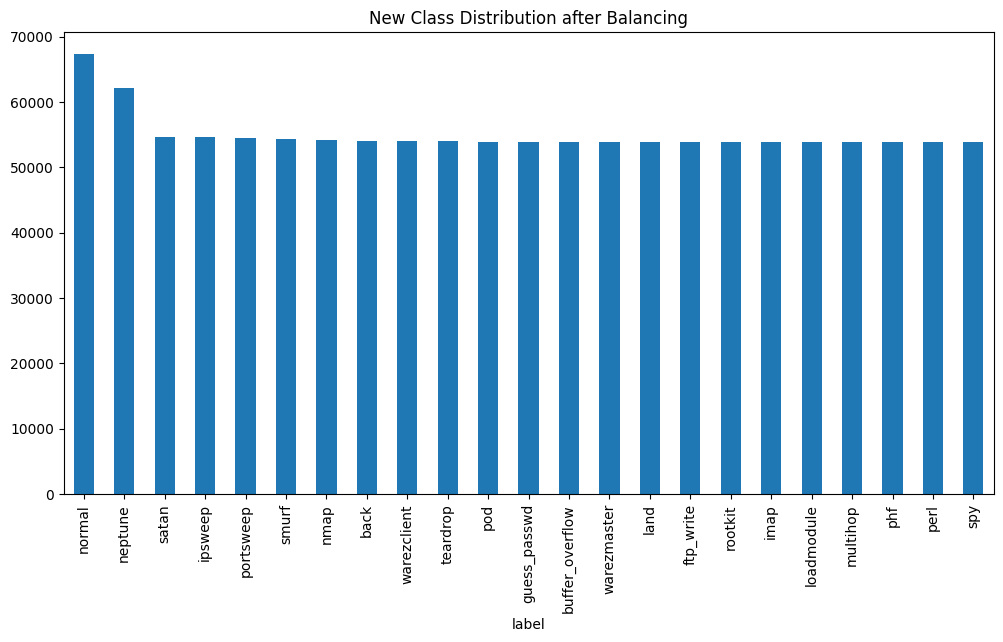

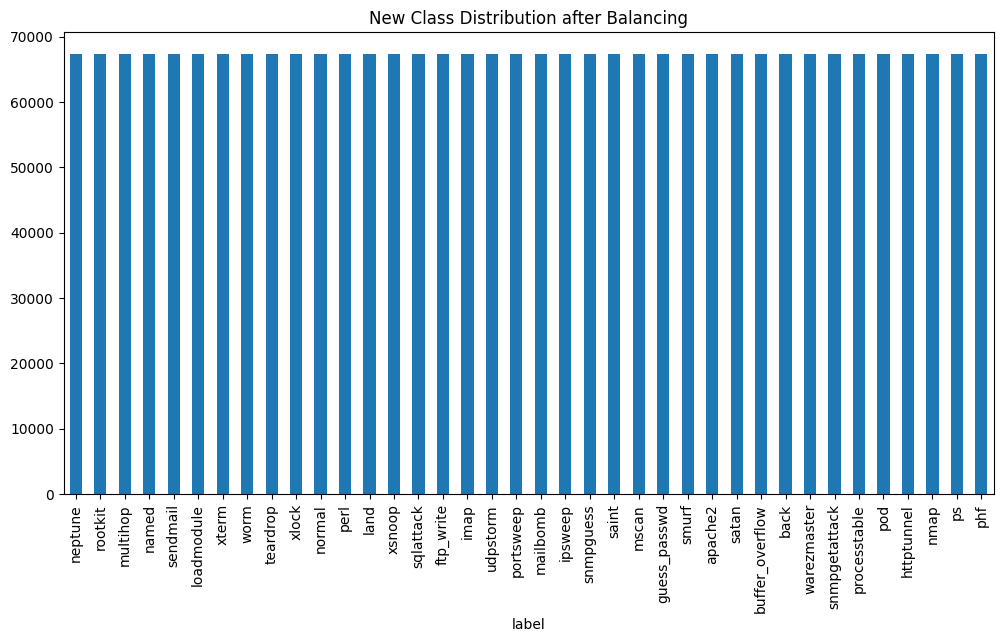

In [ ]:
plt.figure(figsize=(12, 6))
train_df['label'].value_counts().plot(kind='bar', title='New Class Distribution after Balancing')
plt.show()
plt.figure(figsize=(12, 6))
test_df['label'].value_counts().plot(kind='bar', title='New Class Distribution after Balancing')
plt.show()

In [ ]:
class_stats = train_df.groupby('label').agg(['mean', 'std']).reset_index()

print("Class-Wise Statistics:")
print(class_stats)


Class-Wise Statistics:
              label  duration           protocoltype              service  \
                         mean       std         mean       std       mean   
0              back -0.002745  0.070822     0.031439  0.151337   1.312397   
1   buffer_overflow  0.338867  0.245045    -0.661763  0.198436   0.685549   
2         ftp_write -0.149756  0.313002     0.408705  0.247453   0.789138   
3      guess_passwd  0.181447  0.342982     0.207402  0.309071   0.835410   
4              imap -0.274384  0.325629     0.000542  0.299265   0.251070   
5           ipsweep  0.202668  0.056906    -0.002703  0.097777   2.130220   
6              land -0.286314  0.292541    -0.110477  0.296614   0.450747   
7        loadmodule  0.359398  0.281004    -0.310797  0.267934   0.725443   
8          multihop  0.276801  0.289160    -0.420876  0.288722   0.541347   
9           neptune -0.028561  0.040106     0.676255  0.454596  25.713827   
10             nmap  0.052182  0.054299     0.138043 

In [ ]:
X_train = train_df.drop('label', axis=1).to_numpy(dtype=np.float32)
X_test = test_df.drop('label', axis=1).to_numpy(dtype=np.float32)
y_train = train_df['label'].to_numpy()
y_test = test_df['label'].to_numpy()

In [ ]:
def build_encoder(input_dim, embedding_dim):
    return tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),  # First hidden layer
        layers.Dense(embedding_dim, activation=None)  # Latent layer
    ])


In [ ]:
def build_decoder(embedding_dim, output_dim):
    return tf.keras.Sequential([
        layers.Input(shape=(embedding_dim,)),
        layers.Dense(128, activation='relu'),  # Hidden layer
        layers.Dense(output_dim, activation='sigmoid')  # Output layer
    ])


In [ ]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.embeddings = self.add_weight(
            shape=(num_embeddings, embedding_dim),
            initializer='random_uniform',
            trainable=True
        )

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [-1, self.embedding_dim])

        # Compute distances to embeddings
        distances = (
            tf.reduce_sum(flat_inputs**2, axis=1, keepdims=True)
            - 2 * tf.matmul(flat_inputs, self.embeddings, transpose_b=True)
            + tf.reduce_sum(self.embeddings**2, axis=1)
        )

        # Find the closest embeddings
        encoding_indices = tf.argmin(distances, axis=1)
        quantized = tf.nn.embedding_lookup(self.embeddings, encoding_indices)

        # Reshape back to original dimensions
        quantized = tf.reshape(quantized, input_shape)

        # Compute loss for quantization
        e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs) ** 2)
        q_latent_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs)) ** 2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        self.add_loss(loss)

        # Straight-through estimator
        quantized = inputs + tf.stop_gradient(quantized - inputs)
        return quantized


In [ ]:
class VQVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, vector_quantizer, **kwargs):
        super(VQVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.vector_quantizer = vector_quantizer

    def call(self, inputs):
        z = self.encoder(inputs)
        z_quantized = self.vector_quantizer(z)
        reconstructed = self.decoder(z_quantized)
        # Return a dictionary with 'reconstructed' as the key
        return {"reconstructed": reconstructed}


In [ ]:
input_dim = X_train.shape[1]  # Number of features in the dataset
embedding_dim = 32  # Size of the latent space
num_embeddings = 64  # Number of discrete embeddings
commitment_cost = 0.25

In [ ]:
encoder = build_encoder(input_dim, embedding_dim)
decoder = build_decoder(embedding_dim, input_dim)
vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

In [ ]:
vqvae = VQVAE(encoder, decoder, vector_quantizer)

In [ ]:
vqvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError())


In [ ]:
vqvae.fit(X_train, X_train, batch_size=64, epochs=50, verbose=1)


Epoch 1/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 3.1231
Epoch 2/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 3.0154
Epoch 3/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 3.0141
Epoch 4/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 3.0006
Epoch 5/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 2.9804
Epoch 6/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 3.0006
Epoch 7/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 3.0074
Epoch 8/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 3.0106
Epoch 9/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 2.9891
Epoch 10/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 2.9853
Epoch 11/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 2.9996
Epoch 12/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - loss: 2.9905
Epoch 13/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 3.0083
Epoch 14/50
19755/19755 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - 

In [ ]:
# Extract latent features
reconstructed_train = vqvae.predict(X_train)["reconstructed"]
z_train = vqvae.encoder(X_train).numpy()
z_train_quantized = vqvae.vector_quantizer(z_train).numpy()

reconstructed_test = vqvae.predict(X_test)["reconstructed"]
z_test = vqvae.encoder(X_test).numpy()
z_test_quantized = vqvae.vector_quantizer(z_test).numpy()

# Save the features for downstream tasks
np.save('z_train_quantized.npy', z_train_quantized)
np.save('z_test_quantized.npy', z_test_quantized)

print("Features extracted and saved!")

39510/39510 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step
79970/79970 ━━━━━━━━━━━━━━━━━━━━ 115s 1ms/step
Features extracted and saved!


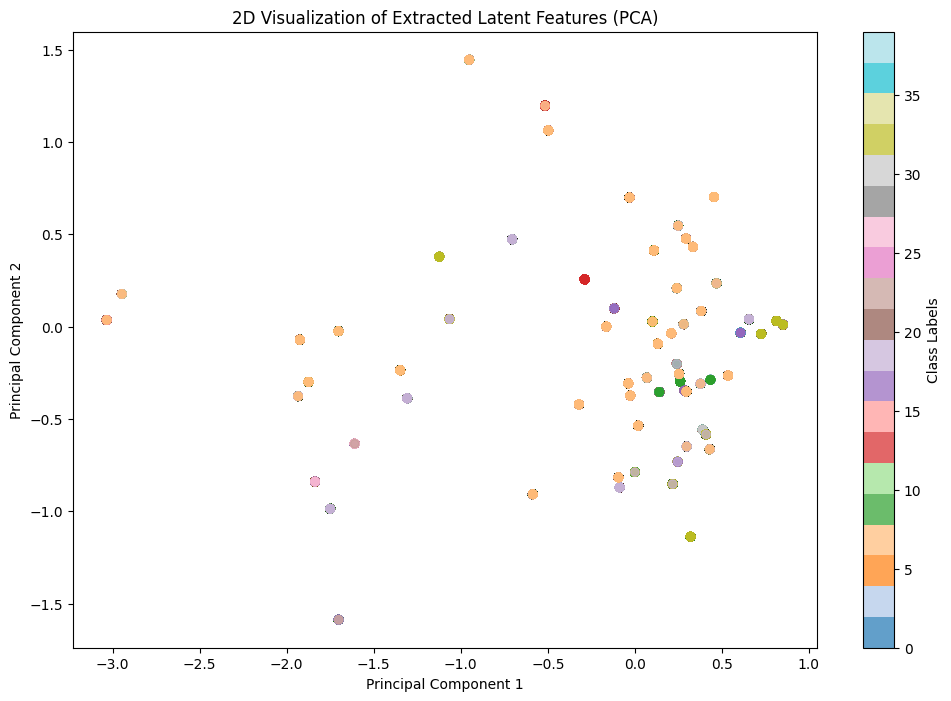

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np  # Import numpy

# Load the saved latent features
z_train_quantized = np.load('z_train_quantized.npy')
z_test_quantized = np.load('z_test_quantized.npy')

# Combine train and test for visualization purposes
z_combined = np.concatenate([z_train_quantized, z_test_quantized], axis=0)
y_combined = np.concatenate([y_train, y_test], axis=0)

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
z_combined_pca = pca.fit_transform(z_combined)

# Convert string labels to numerical values using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_combined_encoded = le.fit_transform(y_combined)  # Encode labels

# Plot the PCA projection
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    z_combined_pca[:, 0],
    z_combined_pca[:, 1],
    c=y_combined_encoded,  # Use encoded labels for color
    cmap='tab20',
    alpha=0.7
)
plt.colorbar(scatter, label="Class Labels")
plt.title("2D Visualization of Extracted Latent Features (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
class VQVAEWithClassifier(VQVAE):
    def __init__(self, encoder, decoder, vector_quantizer, num_classes, **kwargs):
        super(VQVAEWithClassifier, self).__init__(encoder, decoder, vector_quantizer, **kwargs)
        self.classifier = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),  # Add a hidden layer
            layers.Dropout(0.3),
            layers.Dense(num_classes, activation='softmax')  # Output layer
        ])

    def call(self, inputs):
        z = self.encoder(inputs)  # Latent space
        z_quantized = self.vector_quantizer(z)
        reconstructed = self.decoder(z_quantized)
        classification_output = self.classifier(z_quantized)  # Classification from latent space
        # Return a dictionary with named outputs
        return {"loss": reconstructed, "classification": classification_output}

In [ ]:
# Define hyperparameters
num_classes = len(np.unique(y_train))  # Number of unique classes

# Create the model
vqvae_classifier = VQVAEWithClassifier(encoder, decoder, vector_quantizer, num_classes)

# Compile the model with dual loss
vqvae_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "loss": tf.keras.losses.MeanSquaredError(),  # Reconstruction loss
        "classification": tf.keras.losses.SparseCategoricalCrossentropy()  # Classification loss
    },
    metrics={"classification": "accuracy"}
)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Ensure all labels are strings before fitting
all_labels = np.concatenate([y_train.astype(str), y_test.astype(str)])

# Fit LabelEncoder on combined labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Transform y_train and y_test
y_train = label_encoder.transform(y_train.astype(str))
y_test = label_encoder.transform(y_test.astype(str))

In [ ]:
# Train the model
vqvae_classifier.fit(
    X_train, {"loss": X_train, "classification": y_train},  # Dual outputs
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
15804/15804 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - classification_accuracy: 0.9844 - classification_loss: 0.0537 - loss: 3.8414 - loss_loss: 3.6967 - val_classification_accuracy: 0.1465 - val_classification_loss: 27.1735 - val_loss: 28.1109 - val_loss_loss: 0.1868
Epoch 2/10
15804/15804 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - classification_accuracy: 0.9857 - classification_loss: 0.0492 - loss: 3.8127 - loss_loss: 3.6875 - val_classification_accuracy: 0.1474 - val_classification_loss: 23.7209 - val_loss: 24.6010 - val_loss_loss: 0.1874
Epoch 3/10
15804/15804 ━━━━━━━━━━━━━━━━━━━━ 61s 4ms/step - classification_accuracy: 0.9868 - classification_loss: 0.0451 - loss: 3.7994 - loss_loss: 3.6841 - val_classification_accuracy: 0.1475 - val_classification_loss: 24.5830 - val_loss: 25.3892 - val_loss_loss: 0.1911
Epoch 4/10
15804/15804 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - classification_accuracy: 0.9870 - classification_loss: 0.0439 - loss: 3.8140 - loss_loss: 3.6993 - val_classification_accu

In [ ]:
# Evaluate on the test set
loss, reconstruction_loss, classification_loss, classification_accuracy = vqvae_classifier.evaluate(
    X_train, {"loss": X_train, "classification": y_train}
)
print(f"Train Accuracy: {classification_accuracy:.2f}")

39510/39510 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - classification_accuracy: 0.9688 - classification_loss: 0.4737 - loss: 10.2155 - loss_loss: 9.6449
Train Accuracy: 0.82
